# Pysius - a Python solver for Blausius equation

In [1]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt

Let $f(\eta)$ be the non-dimensional stream function, with $\eta$ being the similarity variable. Blausius equation reads:

$$f''' + \frac{1}{2}ff'' = 0$$

This is a third order ODE, that therefore can be cast to a system of 3 first order ODEs:

$$\begin{cases}
f' = u\\
u'  = \xi\\
\xi' = -\frac{1}{2}f\xi
\end{cases}$$

the first two rows representing de-facto the definitions of the additional variables $f$ and $\xi$. Boundary conditions are:

$$f(0)=0$$
$$u(0)=0$$
$$\lim_{\eta \to \infty}u(\eta)=\int_0^\infty \xi d\eta = 1$$

A complete set of initial conditions is not available (the value of $\xi$ at $\eta=0$ is not provided). This makes it impossible to solve the equation with a time $\eta$-marching scheme (meaning, starting from initial conditions towards higher values of eta), hence they need to be solved nonlinearly.

The theoretical domain would be $\eta\in[0,\infty)$; a discretisation is needed. Here, $\infty$ is approximated with a high enough value `eta_max`, while the parameter `N` indicates on how many nodes the function is evaluated (including extremes, so including $0$ and `eta_max`. `deta` is the spacing between nodes.

_Hint: try starting from a low number of nodes and a low value for_ `eta_max` _and gradually increase them. Do this until no substantial change in the final solution is observed._

In [2]:
eta_max = 20 # extreme of domain
N = 1000 # number of nodes
deta = eta_max / (N-1)

Next up, it has to be decided how to store the unknowns in memory. There are three variables, $f$, $u$ and $\xi$, and $N$ nodes - which adds up to $3N$ unknowns. All variables are stored in a one-dimensional array $y$ of size $3N$:

In [3]:
y = np.zeros(3*N)

It is conventionally decided that the first N elements of `y` represent $\xi$ at each of the nodes, namely:
```python
xi = y[0:N] # where xi[n-1] represents xi at the n-th node
```
notice that the first extreme ($0$) is inclusive, the second ($N$) is not. The other variables just follow:
```python
u = y[N:(2*N)]
f = y[(2*N):(3*N)]
```

Using a forward-Euler discretisation, the equation can be evaluated at each node $n$ as:

$$
\left(
\begin{bmatrix}
\xi_{n+1}\\
u_{n+1}\\
f_{n+1}
\end{bmatrix} - 
\begin{bmatrix}
\xi_{n}\\
u_{n}\\
f_{n}
\end{bmatrix} 
\right) \frac{1}{\Delta \eta} +
\begin{bmatrix}
\frac{1}{2}\xi_{n}f_n\\
-\xi_{n}\\
-u_{n}
\end{bmatrix} = 0
$$

Notice that such equation cannot be written for $n=N$ (the last cell), as it would require informations from the cell $N+1$ - which does not exist. Therefore, $3(N-1)$ equations can be written; the remaining 3 equations are provided by boundary conditions, so that the number of equations matches the one of unknowns.

This can be written in the current context as:

$$
Ay + b(y) = 0
$$

where $A$ is a matrix, vector $b$ is a function of y; this is written so that:
- the first $N-1$ rows represent the discretised Blausius equation for $\xi$
- the next row represents the boundary contition for $u(0)$
- the next $N-1$ rows represent the discretised Blausius equation for $u$
- the next 2 rows represents the boundary condition for $u(\infty)$
- the next row is the boundary condition for $f$ at $0$
- the final $N-1$ rows represent the discretised Blausius equation for $f$

In [4]:
# Keep in mind that when slicing or using "range", the first bound is inclusive
# while the second is not!
# In this way, for instance, range(1,11) produces an array of numbers from 1 to 10,
# which has size 11-1 = 10.

A = np.zeros((3*N, 3*N))

# Blausius equation for xi (derivative of xi)
for ii in range(N-1):
    A[ii,ii] = -1/deta
    A[ii,ii+1] = 1/deta

# boundary condition for u(0)
A[N-1, N] = 1

# Blausius equation for u (derivative of u)
for ii in range(N,2*N-1):
    A[ii,ii] = -1/deta
    A[ii,ii+1] = 1/deta

# boundary conditions for u at etamax ~ infinity
A[2*N-1,2*N-1] = 1

# boundary condition for f(0)
A[2*N,2*N] = 1

# Blausius equation for f (derivative of f)
for ii in range(2*N+1, 3*N):
    A[ii,ii-1] = -1/deta
    A[ii,ii] = 1/deta

In [5]:
# now, a function returning vector b is defined

def b(y):
    
    result = np.zeros(3*N)
    
    # Blausius equation for xi (derivative of xi)
    for ii in range(N-1):
        result[ii] = y[ii]*y[2*N+ii]/2
        
    # Blausius equation for u (derivative of u)
    for ii in range(N,2*N-1):
        result[ii] = - y[ii-N]
        
    # boundary conditions for u at etamax ~ infinity
    result[2*N-1] = -1

    # Blausius equation for f (derivative of f)
    for ii in range(2*N+1, 3*N):
        result[ii] = -y[ii-1-N]
    
    return result

In [6]:
# Jacobi's matrix for b; this will come in handy later

def db(y):
    
    result = np.zeros((3*N,3*N))
    
    # Blausius equation for xi (derivative of xi)
    for ii in range(N-1):
        result[ii,2*N+ii] = y[ii]/2
        result[ii,ii] = y[2*N+ii]/2
        
    # Blausius equation for u (derivative of u)
    for ii in range(N,2*N-1):
        result[ii,ii-N] = - 1

    # Blausius equation for f (derivative of f)
    for ii in range(2*N+1, 3*N):
        result[ii,ii-1-N] = -1
        
    return result

We now have a non-linear equation in the form:

$$ F(y) = Ay + b(y) = 0$$

this can be solved with a Newton-Raphson scheme starting from an initial guess `y0`:

$$ y^{\,k+1} = y^{\,k} - J^{-1}(y^{\,k})\, F(y^{\,k}) $$

where $J$ is the Jacobi's matrix of $F$, $k$ denotes the iteration of the algorithm. Iterations are stopped when a maximum of iteratins `KMAX` is reached or the residual $f(y^{\,k})$ is below a threshold value `TOLL`.

In [7]:
# define F and the jacobian J
F = lambda yy : A.dot(yy) + b(yy)
J = lambda yy : A + db(yy)

In [8]:
# initial condition (linear profiles which respect B.C.)
y0 = np.zeros(3*N)
y0[0:N] = 0.5*np.linspace(1.0,0.0,num=N)*deta
y0[N:2*N] = np.linspace(0,1,num=N)
y0[2*N:3*N] = np.linspace(0,1,num=N)

In [9]:
KMAX = 100
TOLL = 1e-10

exit4it = True
for ii in range(KMAX):
    dy = - np.linalg.solve(J(y0),F(y0))
    y = y0 + dy
    y0 = y
    print('Iteration {}, maximum absolute value of residual: {}'.format(ii+1,max(F(y))))
    if max(abs(dy)) < TOLL:
        exit4it = False
        print('Algorithm terminated due to satisfactory residual (number of iterations: {}).'.format(ii+1))
        break
if exit4it:
    print('Warning: algorithm was terminated since the iteration threshold has been reached;')
    print('converngence might have not been achieved.')

Iteration 1, maximum absolute value of residual: 0.18004214181201458
Iteration 2, maximum absolute value of residual: 0.02821815231093361
Iteration 3, maximum absolute value of residual: 0.0060674549531763156
Iteration 4, maximum absolute value of residual: 0.00018820526463683707
Iteration 5, maximum absolute value of residual: 1.5044559759092024e-07
Iteration 6, maximum absolute value of residual: 2.2737367544323206e-13
Iteration 7, maximum absolute value of residual: 1.2312373343092986e-13
Algorithm terminated due to satisfactory residual (number of iterations: 7).


In [10]:
print(y.shape)

(3000,)


Now, the solution is extracted and plotted:

In [11]:
eta = np.linspace(0,eta_max,num=N)
xi = y[0:N]
u = y[N:(2*N)]
f = y[(2*N):(3*N)]
print(eta.shape)
print(f.shape)
print(u.shape)

(1000,)
(1000,)
(1000,)


<IPython.core.display.Javascript object>


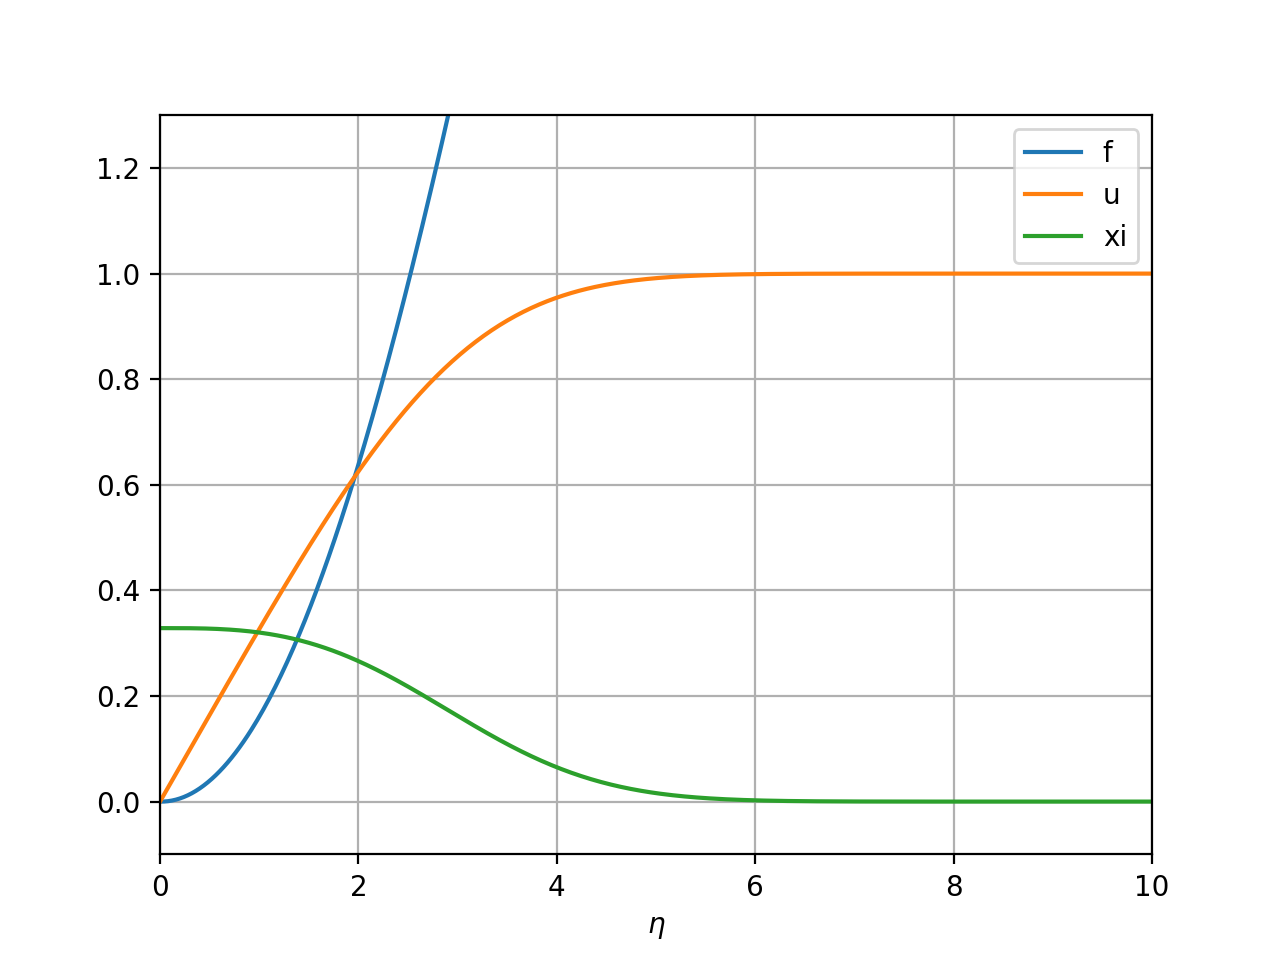

In [12]:
fig, ax = plt.subplots()
ax.plot(eta,f)
ax.plot(eta,u)
ax.plot(eta,xi)
ax.set_xlabel('$\eta$')
ax.set_xlim([0,10])
ax.set_ylim([-0.1,1.3])
ax.grid()
ax.legend(['f', 'u', 'xi'])

# Postprocessing

Now, the streamlines associated to the Blausius solution are plotted in a x,z plane; these correspond to the isocontours of the stream function f. It is thus necessary to find the values of f in real space (as a function of x and y); to do so, a mesh is first created - being careful that the values of $x$ and $y$ do not generate values of $\eta$ exceeding `eta_max`. To each couple $(x,y)$ corresponds a value of $\eta$:

$$ \eta = y\sqrt{\frac{u_\infty}{\nu x}} $$

Here, it is arbitrarily chosen to have $u_\infty / \nu = 1$ - so that $\eta = y/\sqrt{x}$. Knowing $\eta$, it is possible to find the value of $f$ by interpolation of the Blausius solution; hence, it is also possible to calculate the dimensional stream function $\psi$:

$$ \psi = f\sqrt{\nu u_\infty x} $$

In [13]:
# first off: define u_inf and nu
# unitary values are arbitrarily chosen
u_inf = 1
nu = 1

In [14]:
# function that returns eta from x and y
get_eta = lambda x,y : y / math.sqrt(nu*x/u_inf)

In [15]:
# mesh settings
x_min = 0.1; x_max = 1 # bounds for x - notice that x cannot be 0 (see def. of eta)
y_max = 1; # bounds for y
nox = 100; noy = 100 # number of points in each direction

# generate mesh
if get_eta(x_min, y_max) > eta_max:
    print('Warning: requested mesh exceeds the calculated values of eta.')
x, y = np.meshgrid(np.linspace(0.001,x_max,num=nox), np.linspace(0,y_max,num=noy))

In [16]:
# calculate stream function associated to each x, y
psi = np.empty_like(x)
for ii in range(nox):
    for jj in range(noy):
        current_eta = get_eta(x[ii,jj], y[ii,jj])
        psi[ii,jj] = np.interp(current_eta, eta, f) * math.sqrt(nu*u_inf*x[ii,jj])

<IPython.core.display.Javascript object>


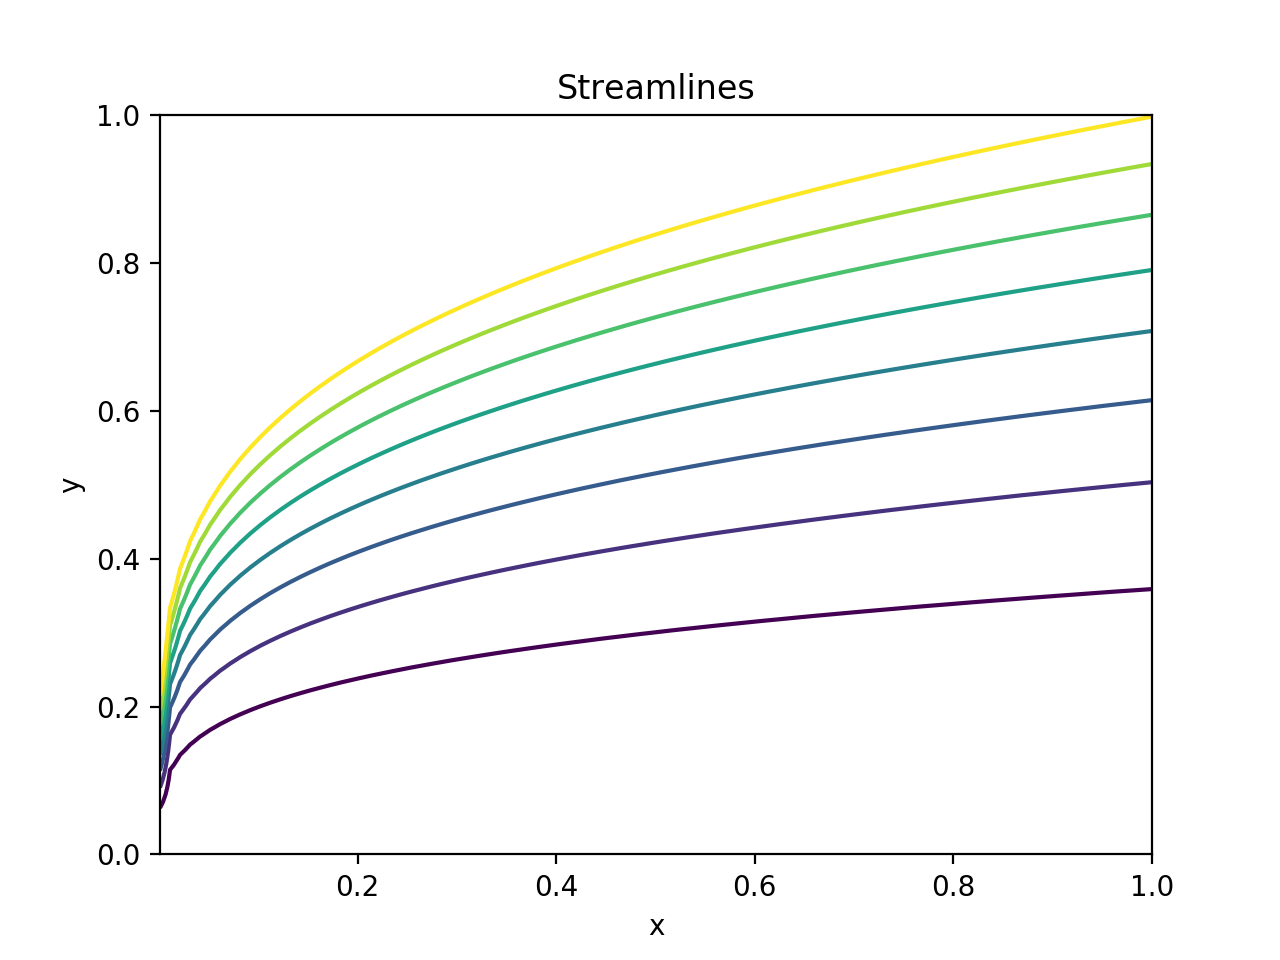

Text(0, 0.5, 'y')

In [17]:
fig, ax = plt.subplots()
ax.contour(x,y,psi,levels=[0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
ax.set_title('Streamlines')
ax.set_xlabel('x')
ax.set_ylabel('y')

And finally, the non-dimensional velocity field can be found as:

$$ u_x = u_\infty \, f' $$

$$ u_y = \sqrt{\frac{\nu u_\infty}{x}} \, \left(\eta\, f' -f \right) $$

In [22]:
# calculate stream function associated to each x, y
ux = np.empty_like(x)
uy = np.empty_like(x)
for ii in range(nox):
    for jj in range(noy):
        current_eta = get_eta(x[ii,jj], y[ii,jj])
        ux[ii,jj] = np.interp(current_eta, eta, u) * u_inf
        uy[ii,jj] = (current_eta*np.interp(current_eta, eta, u) - np.interp(current_eta, eta, f)) * math.sqrt(nu*u_inf/x[ii,jj])

<IPython.core.display.Javascript object>


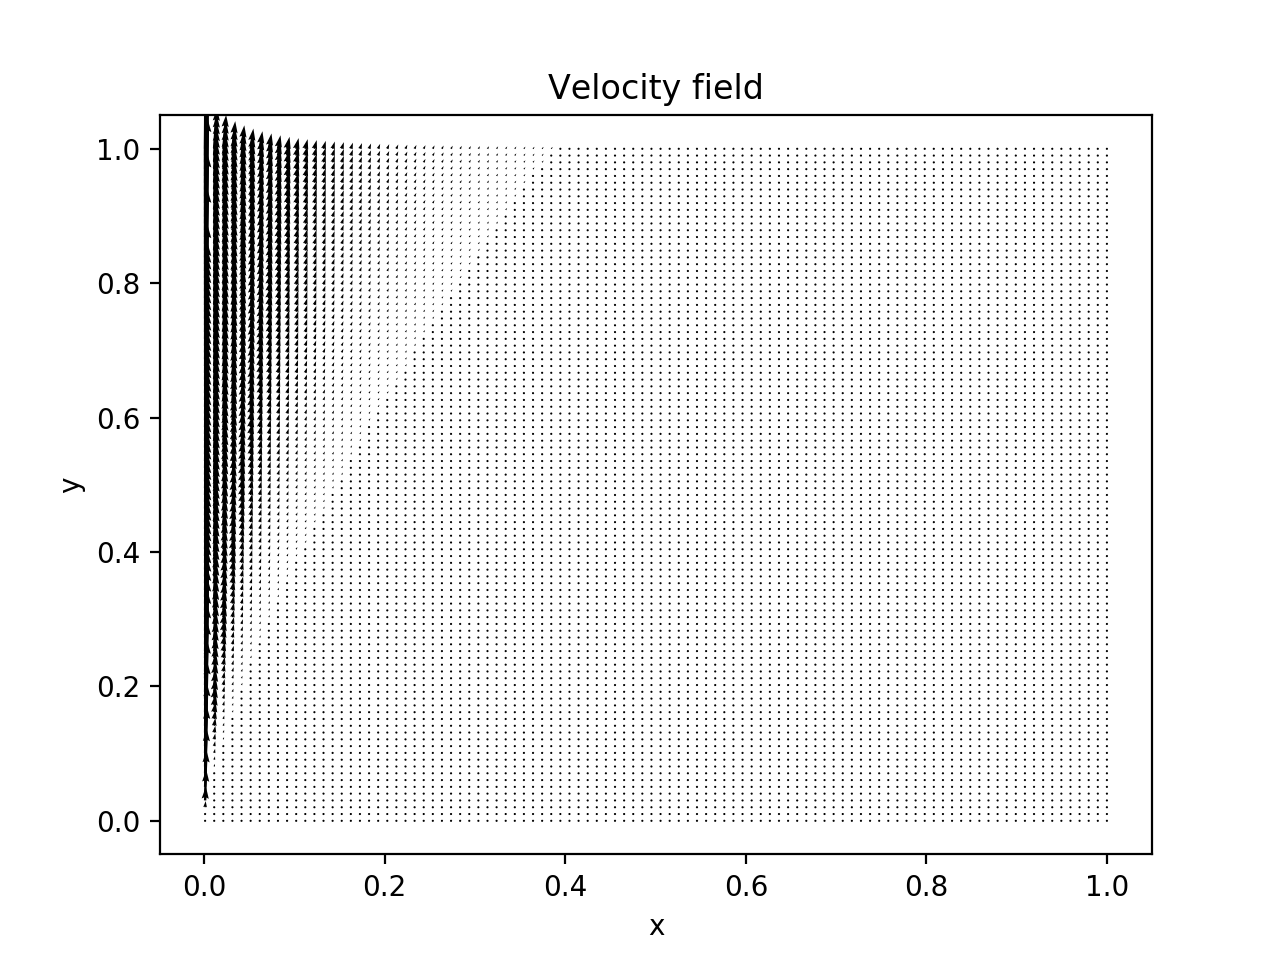

Text(0, 0.5, 'y')

In [23]:
fig, ax = plt.subplots()
ax.quiver(x,y,ux,uy)
ax.set_title('Velocity field')
ax.set_xlabel('x')
ax.set_ylabel('y')